# ガウス過程の周辺尤度最大化

In [1]:
%matplotlib inline 
from IPython.core.display import display, Math, Latex

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.animation as animation
import numpy as np
import pandas as pd
from sympy import *
import sympy
import matplotlib.figure
init_printing()
#from math import *
from interval import interval
from interval import imath
import sys
from pprint import pprint


from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.animation as animation
import numpy as np
from numpy.random import seed
import pandas as pd

## 1. Log marginal likelihood の定義
- $\mathbf{\theta} = (\sigma_f, l, \sigma_n)$
- $ K_{y(pq)} = kernel(\mathbf{x}_p, \mathbf{x}_q, \mathbf{\theta}) + \sigma_n\delta_{pq}$
- $\log(p(\mathbf{y} | X, \mathbf{\theta})) = - 1/2 * \mathbf{y}^TK^{-1}_y\mathbf{y} - 1/2 * \log{|K_y|} - n/2* \log{2\pi}$
- $f(\mathbf{\theta}) = - \log(p(\mathbf{y} | X, \mathbf{\theta}))$
    - $f(\mathbf{\theta})$を最小化する

### 1.1 データの読み込み
- 'generate_psuedo_data_for_regression.ipynb'で作成した 'dump/data_df.pkl'

In [2]:
data_df = pd.read_pickle('dump/data_df.pkl')[:2]
print(len(data_df))
X = np.array(list(data_df.X))
print(X.shape)
y = np.array(data_df.y)
print(X, end='\n')

print(y)

np.sum((X[0] - X[1])**2)

2
(2, 2)
[[  4.90966464e+00   1.16373936e-03]
 [  1.20400978e+00   7.70527111e+00]]
[ 15.18389008  30.05525107]


In [3]:
_X_num= 5
_X_dim =  2
_X = symbols('x1:%d' % (_X_num * _X_dim + 1))

seed(1234)
_X_val = np.array(np.random.uniform(low=0, high=10, size=(100,3)))
print(_X_val.shape)
theta = l, sigma_f, sigma_n = symbols('l sigma_f sigma_n')
display(theta)
display(l)
display(sigma_f)
display(sigma_n)
print(_X)

(100, 3)


(x1, x2, x3, x4, x5, x6, x7, x8, x9, x10)


### 1.2 $K_y$を定義

In [4]:
def kernel(p, q, i, j):
    """
    p,q: np.array
    """
    def rbf(p, q):
        dist = np.sum((p - q) ** 2)
        return exp(-(1. / l**2) * dist)
    
    ans =  (sigma_f**2) * rbf(p, q) + (sigma_n**2) * int(i == j) # 対角成分のみnoiseを追加
    return ans


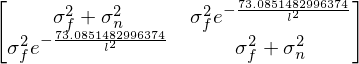

In [5]:
K = Matrix([[kernel(p, q, i, j) for j,q in enumerate(X)] for i,p in enumerate(X)])
display(K)

### 1.3 $\log(p(\mathbf{y} | X, \mathbf{\theta}))$の計算

In [6]:
y = Matrix(y)

def get_log_prob_expr(K, y): 
    K_inv = K.inv('LU')
    first_tem = (1/2.) * (y.T)*(K_inv)*(y)
    second_term = (1/2.) * Matrix([K.det()]).applyfunc(log)
    third_term = Matrix([(len(y)/2.) * log(2*pi)])
    log_prob = - first_tem -  second_term - third_term
    return log_prob[0, 0]


log_prob_expr = get_log_prob_expr(K, y)

## 2. $f(\theta)$の最小化

### 2.1 評価関数 $f(\theta)$ の定義
- $f(\mathbf{\theta}) = - \log(p(\mathbf{y} | X, \mathbf{\theta}))$
    - $f(\mathbf{\theta})$を最小化する

In [7]:
f_expr = - log_prob_expr
#f = lambdify(theta, f_expr, modules=(imath, {'ImmutableDenseMatrix': list}))
f = lambdify(theta, f_expr, modules=(imath))

interval_val = (interval[0.1, 1.7], interval[0.1, 2.6], interval[0.1,1.2])
print(f(*interval_val))
print()
print(f(0.1, 0.1, 0.1))
print(f(1.7, 2.6, 1.2))
print()
print(f(interval[1.35, 1.6], interval[2.45, 2.5], interval[0.8,0.95]))


interval([67.0641052242185, 28350.657881648393])

interval([28344.64172448867, 28344.64172448869])
interval([73.08034261148933, 73.08034261148939])

interval([82.99516377451509, 89.15487870502054])


### 2.2 $\dfrac{\partial}{\partial \theta}f(\theta)$の計算

In [8]:
df_expr = [[f_expr.diff(_theta)] for _theta in theta]
print(type(df_expr))
df = lambdify(theta, df_expr, modules=(imath, {'ImmutableDenseMatrix': list}))
print(type(df))

<class 'list'>
<class 'function'>


### 2.3 $\dfrac{\partial^{2}}{\partial \theta^{2}}f(\theta)$の計算

In [9]:
ddf_expr = hessian(f_expr, theta)
print(type(ddf_expr))
ddf = lambdify(theta, ddf_expr, modules=(imath, {'ImmutableDenseMatrix': list}))
print(type(ddf))

<class 'sympy.matrices.dense.MutableDenseMatrix'>
<class 'function'>
